In [1]:
import pandas as pd
from gse.gse import create_model, instantiate_model, solve_model, get_results
from gse.gse_input import create_input
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FixedLocator, MultipleLocator

Get COIN-OR Cbc solver from https://github.com/coin-or/Cbc/releases. Other linear programming solvers can also work.

Set the solver path

In [2]:
solver = {'name':"cbc", 'path':"Path to solver"}

Import data

In [3]:
df_load = pd.read_csv('./examples/data/load.csv', index_col = 0, parse_dates = True)
df_pv = pd.read_csv('./examples/data/pv.csv', index_col = 0, parse_dates = True)
df_grid = pd.read_csv('./examples/data/grid.csv', index_col = 0, parse_dates = True)/100 # Convert €¢/kWh --> €/kWh
df_battery = pd.read_csv('./examples/data/battery.csv', index_col = 0)

Use the data dataframes to get the names of the houses.

In [4]:
houses_with_demand = list(df_load.columns)
houses_with_generation = list(df_pv.columns)
houses_with_battery = list(df_battery.columns)
houses = list(set(houses_with_demand+houses_with_generation+houses_with_battery))

Run the base scenario where every house operates individually buying or selling electricity to the grid.

In [ ]:
# Base scenario - Individual house operation

battery_soc_base = pd.DataFrame(index = df_load.index, columns=houses)
battery_charge_base = pd.DataFrame(index = df_load.index, columns=houses)
power_buy_base = pd.DataFrame(index = df_load.index, columns=houses)
power_sell_base = pd.DataFrame(index = df_load.index, columns=houses)
cost_energy_base_ = pd.DataFrame(index = df_load.index, columns=houses)
cost_grid_base_ = pd.DataFrame(index = df_load.index, columns=houses)

for h in houses:
    
    load_data = df_load[[h]] if h in df_load.columns else pd.DataFrame(index = df_load.index)
    generation_data = df_pv[[h]] if h in df_pv.columns else pd.DataFrame(index = df_load.index)
    battery_data = df_battery[[h]] if h in df_battery.columns else pd.DataFrame(index = df_load.index)
    grid_data = df_grid

    # Create data input for model
    model_data = create_input(load_data,generation_data,grid_data,battery_data)
    # Create model
    mdl = create_model()
    # Instantiate model with data
    m = instantiate_model(mdl, model_data)
    # Solve model
    s = solve_model(m, solver) 
    # Get solution as python dictionary
    sd = get_results(s)
    
    battery_soc_base.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
    battery_charge_base.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
    power_buy_base.loc[:,h] = sd['power_buy'][h] if h in sd['power_buy'].keys() else 0.0
    power_sell_base.loc[:,h] = sd['power_sell'][h] if h in sd['power_sell'].keys() else 0.0
    cost_energy_base_.loc[:,h] = sd['cost_energy']
    cost_grid_base_.loc[:,h] = sd['cost_grid']

cost_energy_base = cost_energy_base_.sum(axis=1).to_frame(name = 'Energy Cost')
cost_grid_base = cost_grid_base_.sum(axis=1).to_frame(name = 'Grid Cost')

cost_energy_base_total = cost_energy_base.sum()[0]
cost_grid_base_total = cost_grid_base.sum()[0]
cost_base_total = cost_energy_base_total + cost_grid_base_total

Run the community scenario where the houses operate insise an energy community and they first trade electricity inside the community before trading with the grid.

In [ ]:
# Community scenario - Operation as energy community

battery_soc_community = pd.DataFrame(index = df_load.index, columns=houses)
battery_charge_community = pd.DataFrame(index = df_load.index, columns=houses)
power_buy_community = pd.DataFrame(index = df_load.index, columns=houses)
power_sell_community = pd.DataFrame(index = df_load.index, columns=houses)
cost_energy_community = pd.DataFrame(index = df_load.index, columns=['Energy Cost'])
cost_grid_community = pd.DataFrame(index = df_load.index, columns=['Grid Cost'])

load_data = df_load
generation_data = df_pv
battery_data = df_battery
grid_data = df_grid

# Create data input for model
model_data = create_input(load_data,generation_data,grid_data,battery_data)
# Create model
mdl = create_model()
# Instantiate model with data
m = instantiate_model(mdl, model_data)
# Solve model
s = solve_model(m, solver) 
# Get solution as python dictionary
sd = get_results(s)


for h in houses:
    battery_soc_community.loc[:,h] = sd['battery_soc'][h] if h in sd['battery_soc'].keys() else 0.0
    battery_charge_community.loc[:,h] = sd['battery_charge'][h] if h in sd['battery_charge'].keys() else 0.0
    power_buy_community.loc[:,h] = sd['power_buy'][h] if h in sd['power_buy'].keys() else 0.0
    power_sell_community.loc[:,h] = sd['power_sell'][h] if h in sd['power_sell'].keys() else 0.0

cost_energy_community['Energy Cost'] = sd['cost_energy']
cost_grid_community['Grid Cost'] = sd['cost_grid']

cost_energy_community_total = cost_energy_community.sum()[0]
cost_grid_community_total = cost_grid_community.sum()[0]
cost_community_total = cost_energy_community_total + cost_grid_community_total

Gather all costs into a dataframe

In [7]:
costs = [[cost_energy_base_total,cost_grid_base_total,cost_base_total],
     [cost_energy_community_total,cost_grid_community_total,cost_community_total]]
costs = pd.DataFrame(costs, columns=['Energy Cost','Grid Cost', 'Total Cost'])

The following plot compares the operation costs of the two scenarios. While the energy cost is the same in both scenarios (it is negative because the community PV generation is higher than the community load), the grid cost is lower in the energy community operation which results in lower total cost.

<Figure size 1000x1000 with 0 Axes>

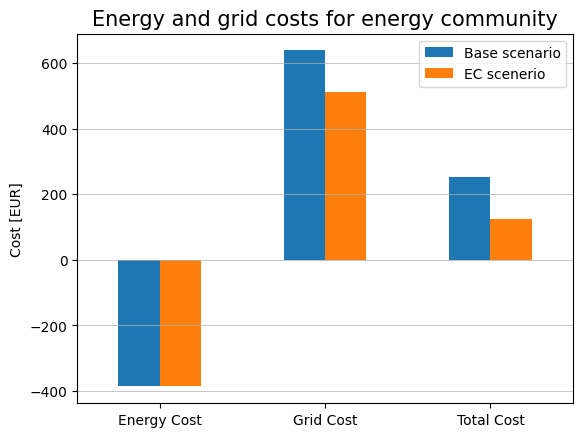

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = costs.T.plot(kind='bar', rot=0, legend=True)
ax.set_title('Energy and grid costs for energy community', fontsize=15)
ax.set_ylabel('Cost [EUR]', fontsize=10)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom=True, labelleft=True)
ax.legend(['Base scenario', 'EC scenerio'], loc=0, fontsize=10)
ax.grid(axis = 'y', linestyle='-', linewidth=0.5)

The following plot shows the operation of the batteries and how their state-of-charge is changing with the time.

<Figure size 2000x1000 with 0 Axes>

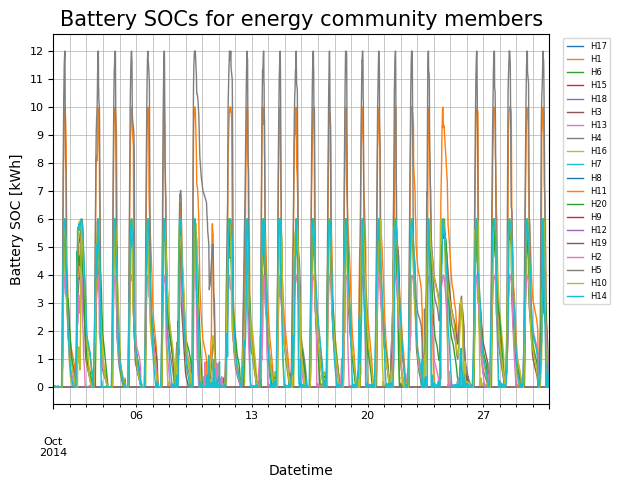

In [9]:
fig = plt.figure(figsize=(20, 10))
ax = battery_soc_community.plot(kind='line', rot=0, legend=False, linewidth=1.0)
ax.set_title('Battery SOCs for energy community members', fontsize=15)
ax.set_ylabel('Battery SOC [kWh]', fontsize=10)
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.tick_params(axis='both', which='both', labelsize=8, 
               labelbottom=True, labelleft=True)
ax.grid(which = 'both', linestyle='-', linewidth=0.5)
ax.legend(fontsize=6,bbox_to_anchor=(1.02, 1.0)) 